In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.datasets import mnist  


In [3]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
import cv2
import os
import numpy as np
def pad_to_square(img, pad_value=0):
    """Pad the image to make it square (for uniform 28x28 resizing)."""
    h, w = img.shape
    diff = abs(h - w)
    if h > w:
        pad_left = diff // 2
        pad_right = diff - pad_left
        padded = cv2.copyMakeBorder(img, 0, 0, pad_left, pad_right, cv2.BORDER_CONSTANT, value=pad_value)
    else:
        pad_top = diff // 2
        pad_bottom = diff - pad_top
        padded = cv2.copyMakeBorder(img, pad_top, pad_bottom, 0, 0, cv2.BORDER_CONSTANT, value=pad_value)
    return padded
def extract_digits_from_page(image_path, save_dir, label, min_width=10, min_height=10, preview=False):
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    contours, _ = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    print(f"\n📄 Processing: {image_path} | Detected: {len(contours)} blobs")
    bounding_boxes = [cv2.boundingRect(c) for c in contours]
    bounding_boxes.sort(key=lambda b: (b[1], b[0]))  # sort top-to-bottom, then left-to-right
    save_path = os.path.join(save_dir, str(label))
    os.makedirs(save_path, exist_ok=True)
    count = 0
    for i, (x, y, w, h) in enumerate(bounding_boxes):
        if w >= min_width and h >= min_height:
            roi = thresh[y:y+h, x:x+w]
            roi_padded = pad_to_square(roi)
            digit_resized = cv2.resize(roi_padded, (28, 28), interpolation=cv2.INTER_AREA)
            file_path = os.path.join(save_path, f"{label}_{count}.png")
            cv2.imwrite(file_path, digit_resized)
            count += 1
            if preview:
                cv2.imshow("Digit", digit_resized)
                key = cv2.waitKey(150)
                if key == 27:  # Esc key to stop preview
                    break
    if preview:
        cv2.destroyAllWindows()
        
    print(f"✅ Saved {count} digits to {save_path}")
def process_folder(folder_path, save_dir):
    for file_name in os.listdir(folder_path):
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            # Example file naming: digit_4_page1.jpg → label = 4
            try:
                label = int(file_name.split('_')[1])  # assumes format: digit_4_page1.jpg
            except:
                print(f"⚠️ Skipping {file_name} (could not determine label)")
                continue
            image_path = os.path.join(folder_path, file_name)
            extract_digits_from_page(image_path, save_dir, label, preview=False)

In [6]:
process_folder(r"C:\Users\akanksha meshram\OneDrive\Documents\Desktop\Digit_Prediction\raw_digit_pages","custom_digit")



📄 Processing: C:\Users\akanksha meshram\OneDrive\Documents\Desktop\Digit_Prediction\raw_digit_pages\digit_0_page1.jpg | Detected: 55 blobs
✅ Saved 26 digits to custom_digit\0

📄 Processing: C:\Users\akanksha meshram\OneDrive\Documents\Desktop\Digit_Prediction\raw_digit_pages\digit_0_page11.jpg | Detected: 314 blobs
✅ Saved 60 digits to custom_digit\0

📄 Processing: C:\Users\akanksha meshram\OneDrive\Documents\Desktop\Digit_Prediction\raw_digit_pages\digit_1_page13.jpg | Detected: 136 blobs
✅ Saved 35 digits to custom_digit\1

📄 Processing: C:\Users\akanksha meshram\OneDrive\Documents\Desktop\Digit_Prediction\raw_digit_pages\digit_1_page2.jpg | Detected: 64 blobs
✅ Saved 23 digits to custom_digit\1

📄 Processing: C:\Users\akanksha meshram\OneDrive\Documents\Desktop\Digit_Prediction\raw_digit_pages\digit_2_page14.jpg | Detected: 198 blobs
✅ Saved 58 digits to custom_digit\2

📄 Processing: C:\Users\akanksha meshram\OneDrive\Documents\Desktop\Digit_Prediction\raw_digit_pages\digit_2_page3

In [7]:
import cv2
import numpy as np
import os
import random
def add_noise(img):
    noise = np.random.randint(0, 50, img.shape, dtype='uint8')
    return cv2.add(img, noise)
def rotate_image(img, angle):
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
    return cv2.warpAffine(img, M, (w, h), borderValue=255)
def shift_image(img, x_shift, y_shift):
    M = np.float32([[1, 0, x_shift], [0, 1, y_shift]])
    return cv2.warpAffine(img, M, (img.shape[1], img.shape[0]), borderValue=255)
def scale_image(img, fx, fy):
    return cv2.resize(img, None, fx=fx, fy=fy, interpolation=cv2.INTER_LINEAR)
def invert_image(img):
    return 255 - img
# Augment images in-place inside 'custom_digits' folder
base_dir = r"C:\Users\akanksha meshram\OneDrive\Documents\Desktop\Digit_Prediction\custom_digit"
for digit in os.listdir(base_dir):
    digit_path = os.path.join(base_dir, digit)
    if not os.path.isdir(digit_path):
        continue
    image_files = [f for f in os.listdir(digit_path) if f.endswith((".png", ".jpg", ".jpeg"))]
    for img_name in image_files:
        img_path = os.path.join(digit_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue
        # Generate 3 augmentations per image
        for i in range(3):
            rotated = rotate_image(img, angle=random.choice([-15, -10, 10, 15]))
            shifted = shift_image(rotated, random.randint(-3, 3), random.randint(-3, 3))
            noisy = add_noise(shifted)
            final = invert_image(noisy) if random.random() < 0.5 else noisy
            new_filename = f"{os.path.splitext(img_name)[0]}_aug{i}.png"
            new_path = os.path.join(digit_path, new_filename)
            cv2.imwrite(new_path, final)

In [ ]:
def load_custom_digits(base_dir):
    images, labels = [], []
    for label in range(10):  # Assuming folders '0' to '9'
        folder = os.path.join(base_dir, str(label))
        if not os.path.isdir(folder):
            continue
        for fname in os.listdir(folder):
            if fname.lower().endswith((".png", ".jpg", ".jpeg")):
                img_path = os.path.join(folder, fname)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None:
                    continue
                img = img.astype("float32") / 255.0
                images.append(np.expand_dims(img, -1))
                labels.append(label)
    return np.array(images), np.array(labels)

custom_data_dir = r"C:\Users\akanksha meshram\OneDrive\Documents\Desktop\Digit_Prediction\custom_digit"
x_custom, y_custom = load_custom_digits(custom_data_dir)


In [8]:
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Expand dims to add channel for grayscale
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)


In [9]:
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)
y_custom = to_categorical(y_custom, 10)
y_train.shape, y_test.shape, y_custom.shape

((60000, 10), (10000, 10), (10905, 10))

In [10]:
x_train_combined = np.concatenate((x_train, x_custom), axis=0)
y_train_combined = np.concatenate((y_train, y_custom), axis=0)

print(f"Combined training data shape: {x_train_combined.shape}")
print(f"Combined training labels shape: {y_train_combined.shape}")

Combined training data shape: (70905, 28, 28, 1)
Combined training labels shape: (70905, 10)


In [11]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\akanksha meshram\anaconda3\envs\tf_env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define ImageDataGenerator with augmentations similar to your OpenCV ones
datagen = ImageDataGenerator(
    rotation_range=15,        # rotate images randomly up to ±15 degrees
    width_shift_range=0.1,    # horizontal shift up to 10%
    height_shift_range=0.1,   # vertical shift up to 10%
    shear_range=0.1,          # shear angle in counter-clockwise direction in degrees
    zoom_range=0.1,           # zoom in/out
    fill_mode='nearest'       # fill missing pixels with nearest values
)

# Fit generator to your combined training data (optional for some augmentations)
datagen.fit(x_train_combined)


In [14]:
batch_size = 128
epochs = 10

# Fit the datagen on the combined training data (optional for some augmentations)
datagen.fit(x_train_combined)

from sklearn.model_selection import train_test_split

# Split combined data into train and validation sets
x_train_final, x_val, y_train_final, y_val = train_test_split(
    x_train_combined, y_train_combined, test_size=0.1, random_state=42
)

# Use the generator only on the training data
train_generator = datagen.flow(x_train_final, y_train_final, batch_size=batch_size)

# Train with validation data separately (pass x_val, y_val as validation_data)
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=(x_val, y_val),
    steps_per_epoch=len(x_train_final) // batch_size
)


c:\Users\akanksha meshram\anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 50s 93ms/step - accuracy: 0.5945 - loss: 1.1942 - val_accuracy: 0.8938 - val_loss: 0.3275
Epoch 2/10
  1/498 ━━━━━━━━━━━━━━━━━━━━ 21s 44ms/step - accuracy: 0.8438 - loss: 0.4610

c:\Users\akanksha meshram\anaconda3\envs\tf_env\lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8438 - loss: 0.4610 - val_accuracy: 0.8940 - val_loss: 0.3274
Epoch 3/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 46s 93ms/step - accuracy: 0.8350 - loss: 0.5052 - val_accuracy: 0.9172 - val_loss: 0.2648
Epoch 4/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8906 - loss: 0.3605 - val_accuracy: 0.9167 - val_loss: 0.2660
Epoch 5/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 47s 95ms/step - accuracy: 0.8620 - loss: 0.4258 - val_accuracy: 0.9193 - val_loss: 0.2396
Epoch 6/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8828 - loss: 0.3311 - val_accuracy: 0.9185 - val_loss: 0.2421
Epoch 7/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 43s 87ms/step - accuracy: 0.8771 - loss: 0.3752 - val_accuracy: 0.9251 - val_loss: 0.2240
Epoch 8/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8906 - loss: 0.3080 - val_accuracy: 0.9237 - val_loss: 0.2264
Epoch 9/10
498/498 ━━━━━━━━━━━━━━━━━━━━ 47s 95ms/step - accuracy: 0.8825 - loss: 0.3536 - val_accuracy: 0.924

In [17]:
# After model.fit(...)
model.save('my_digit_model.h5')
print("Model saved to my_digit_model.h5")


Model saved to my_digit_model.h5


In [18]:
from tensorflow.keras.models import load_model

model = load_model('my_digit_model.h5')
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,036 (879.05 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [20]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)
print(f"MNIST test accuracy: {test_accuracy:.4f}")

# 10. Evaluate on custom dataset
custom_loss, custom_accuracy = model.evaluate(x_custom, y_custom, verbose=0)
print(f"Custom dataset accuracy: {custom_accuracy:.4f}")


MNIST test accuracy: 0.9878
Custom dataset accuracy: 0.5908


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


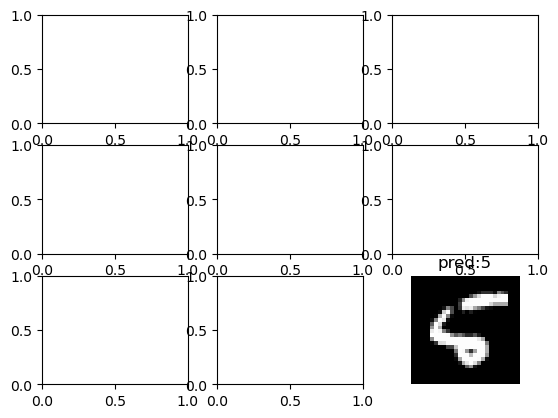

In [22]:
from matplotlib import pyplot as plt
predictions = model.predict(x_test[:9])
for i in range(9):
    plt.subplot(3,3,i+1)
plt.imshow(x_test[i].reshape(28,28),cmap='gray')
plt.title(f"pred:{np.argmax(predictions[i])}")
plt.axis('off')
plt.show()